<a href="https://colab.research.google.com/github/RBENJAMINFRANKLIN/SBSPS-Challenge-1160-Predicting-the-energy-output-of-wind-turbine-based-on-weather-condition/blob/master/SBSPS-Challenge-1160-Predicting-the-energy-output-of-wind-turbine-based-on-weather-condition/03%20Building%20Models%20-%20Deep%20Learning%20Models/windspeedlstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy as np
import pandas as pd

In [2]:
# window_size = 10
batch_size_exp = 1
epoch_exp = 7
neurons_exp = 50
predict_values_exp = 72
lag_exp=72

In [3]:
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [4]:

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [5]:
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [6]:
def scale(data_norm):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(data_norm)
    # transform train
    data_norm = data_norm.reshape(data_norm.shape[0], data_norm.shape[1])
    data_scaled = scaler.transform(data_norm)
    return scaler, data_scaled


In [7]:
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [8]:
from keras.layers import Activation, Dense, BatchNormalization, TimeDistributed
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons_exp, dropout = 0.1 ,batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(BatchNormalization())
    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dense(50))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [9]:
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    #print(X)
    yhat = model.predict(X, batch_size=1)
    return yhat[0,0]


In [10]:
import pandas as pd
series = pd.read_csv('../data/T1.csv',index_col="Date/Time")
series.head()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
Date/Time,,,,
01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
01 01 2018 00:30,419.645904,5.659674,516.127569,271.258087
01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [11]:
#del series['Air temperature | (\'C)']
del series['LV ActivePower (kW)']
del series['Wind Direction (°)']
del series['Theoretical_Power_Curve (KWh)']
series.head()

,Wind Speed (m/s)
Date/Time,
01 01 2018 00:00,5.311336
01 01 2018 00:10,5.672167
01 01 2018 00:20,5.216037
01 01 2018 00:30,5.659674
01 01 2018 00:40,5.577941


In [12]:
for i in range(0,10):
  series = series[:-1]
series.tail()

,Wind Speed (m/s)
Date/Time,
31 12 2018 21:30,8.472826
31 12 2018 21:40,8.433422
31 12 2018 21:50,9.976660
31 12 2018 22:00,10.416830
31 12 2018 22:10,10.713670


In [13]:
series.shape

(50520, 1)

In [14]:
raw_values = series.values
diff_values = difference(raw_values, 1)

In [15]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, lag_exp)
supervised_values = supervised.values

In [16]:
# split data into train and test-sets
scaler,supervised_values = scale(supervised_values)
train_scaled, test_scaled = supervised_values[0:-predict_values_exp], supervised_values[-predict_values_exp:]
#print(test_scaled)

In [17]:
lstm_model = fit_lstm(train_scaled, batch_size_exp, epoch_exp, neurons_exp)


50447/50447 [==============================] - 154s 3ms/step - loss: 0.0018


In [18]:
# walk-forward validation on the test data
predictions = list()
expectations = list()
test_pred = list()

for i in range(len(test_scaled)):
#     window_prediction_frame = test_scaled
#     test_pred = list()
#     for j in range(window_size):
#         X, y = window_prediction_frame[i, 0:-1], window_prediction_frame[i, -1]
#         yhat = forecast_lstm(lstm_model, 1, X)#batch_size_exp to 1
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)#batch_size_exp to 1
    '''# Start Debug prints
    print("X: %", X)
    print("yhat: %", yhat)
    # End Debug prints'''
    # Replacing value in test scaled with the predicted value.
    test_pred = [yhat] + test_pred 
    if len(test_pred) > lag_exp+1:
        test_pred = test_pred[:-1]
    if i+1<len(test_scaled):
        if i+1 > lag_exp+1:
            test_scaled[i+1] = test_pred
        else:
            test_scaled[i+1] = np.concatenate((test_pred, test_scaled[i+1, i+1:]),axis=0)

    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    expected = raw_values[len(train_scaled) + i + 1]
    if expected != 0:
        predictions.append(yhat)
        expectations.append(expected)
    #print('Hour=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 26ms/step


In [19]:
expectations = np.array(expectations)
predictions = np.array(predictions)
print("Mean Absolute Percent Error: ", (np.mean(np.abs((expectations - predictions) / expectations.mean()))*100))
print(predictions)

Mean Absolute Percent Error:  9.121025770618724
[[ 2.99801819]
 [ 2.42521281]
 [ 2.56309681]
 [ 2.73395108]
 [ 2.47661643]
 [ 1.64768844]
 [ 2.34081111]
 [ 2.44486429]
 [ 2.99421995]
 [ 2.75239865]
 [ 3.8961442 ]
 [ 3.05904693]
 [ 2.88949952]
 [ 2.66038171]
 [ 2.85317179]
 [ 3.13274726]
 [ 3.80668875]
 [ 3.01731681]
 [ 2.94487535]
 [ 2.60602393]
 [ 2.71238319]
 [ 3.5966293 ]
 [ 4.49444047]
 [ 4.3316797 ]
 [ 3.99082879]
 [ 4.05619346]
 [ 4.17519406]
 [ 4.46446857]
 [ 5.26599117]
 [ 5.85353136]
 [ 5.81131383]
 [ 6.06313683]
 [ 5.86171598]
 [ 5.42933312]
 [ 5.98440416]
 [ 7.61129774]
 [ 8.212597  ]
 [ 8.13378857]
 [ 8.55575462]
 [ 7.88595879]
 [ 5.72351672]
 [ 4.79083097]
 [ 4.5839221 ]
 [ 4.76034051]
 [ 4.46962919]
 [ 4.55697661]
 [ 4.50165533]
 [ 4.49262562]
 [ 4.52684654]
 [ 4.78969011]
 [ 4.77485002]
 [ 4.84885837]
 [ 4.98075467]
 [ 5.18362401]
 [ 5.75376112]
 [ 5.4377906 ]
 [ 6.12896875]
 [ 7.91336092]
 [ 8.33109906]
 [ 8.68939246]
 [ 8.16517428]
 [ 7.4894342 ]
 [ 7.48241999]
 [ 7.71

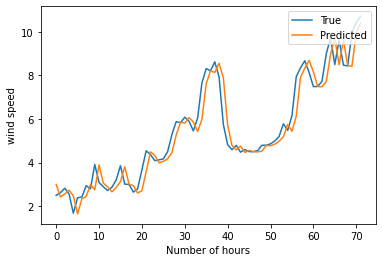

In [20]:
# line plot of observed vs predicted
# fig = pyplot.figure(figsize=(20,8))
pyplot.plot(expectations, label="True")
pyplot.plot(predictions, label="Predicted")
pyplot.legend(loc='upper right')
pyplot.xlabel("Number of hours")
pyplot.ylabel("wind speed")
pyplot.show()

In [21]:
# import pickle 

In [22]:
Pkl_Filename = "Pickle_RL1_Model.h5"  

lstm_model.save(Pkl_Filename)

In [23]:
from keras.models import load_model 
    
Pickled_LR_Model = load_model(Pkl_Filename)

Pickled_LR_Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 50)                   24600     
                                                                 
 batch_normalization (BatchN  (1, 50)                  200       
 ormalization)                                                   
                                                                 
 dense (Dense)               (1, 50)                   2550      
                                                                 
 activation (Activation)     (1, 50)                   0         
                                                                 
 dense_1 (Dense)             (1, 50)                   2550      
                                                                 
 activation_1 (Activation)   (1, 50)                   0         
                                                        

In [24]:
from sklearn.metrics import r2_score, mean_squared_error

print(len(expectations))
print(len(predictions))

print('Score: ', r2_score(expectations, predictions) * 100)


72
72
Score:  91.57634438624349
